# Calculate CATD and NDVI

#### Computes CATD and NDVI for a point location.
1. Download images from STAC.
2. Define point location.

In [32]:
import json
import requests
import pystac
from pystac_client import Client
from pprint import pprint

from botocore.exceptions import ClientError
from shapely.geometry import box, mapping, Point, Polygon

from pyproj.crs import CRS
import pandas as pd
import geopandas as gpd

import xarray as xr
import rioxarray as rxr
import rasterio as rio

from matplotlib import pyplot as plt
import numpy as np

from FH_Hydrosat import FH_StackedDataset
from FH_Hydrosat import FH_Hydrosat

import os
import base64
from datetime import datetime
from datetime import date

If you see `ERROR 1: PROJ: proj_create_from_database: Open of /opt/conda/share/proj failed`, do not fret, and proceed.

### Logging in to the Fusion database.

This next cell opens a file `creds.json` which you will need to create in the same directory 
as the notebook. The format of the file should be:

{
"username":"your_username",
"password":"your_password"
}

and you have updated with your username and password. 

In [33]:
with open('creds.json') as f:
    creds = json.loads(f.read())

# Endecode the `username:password` combination 
# and use it to authorize access to the STAC API given by the `cat_url` 
# endpoint.userpass = f"{creds['username']}:{creds['password']}"
userpass = f"{creds['username']}:{creds['password']}"
b64 = base64.b64encode(userpass.encode()).decode()
headers = {'Authorization':'Basic ' + b64}

cat_url = 'https://fusion-stac.hydrosat.com'
catalog = Client.open(cat_url, headers)

### Set variables for STAC search.
We'll search for data in the `starfm_predictions_modis_landsat` and `pydms_sharpened_landsat` collections which intersect a point location between a start date and an end date and print out the number of items. 

In [34]:
# Specifiy location and time frame for image download.
from distutils.command import sdist

site_name = 'ames'
lat = 42.0    # Edit this. ***************
lon = -93.7   # Edit this. ***************
geom = {'type': 'Point', 'coordinates': [lon, lat]} 

# Specify dates & hour for LST analysis.
start = "2020-04-01"  # Edit this. ***************
end = "2020-10-30"  # Edit this. ***************
hr = "00:00:00"  # Edit this. ***************

# LST collections to search.
lst_collections = ["starfm_predictions_modis_landsat", "pydms_sharpened_landsat"]
# NDVI collections to search.
ndvi_collections = ["prepped_inputs_s2"]

# We need the total num of days for the analysis to get hrrr data.
f = start.split("-")
l = end.split("-")

f_dt = date(int(f[0]), int(f[1]), int(f[2]))  
l_dt = date(int(l[0]), int(l[1]), int(l[2]))  
num_days = (l_dt - f_dt)
num_days = num_days.days

# Need to do some formating for various requirements.
hr_form = "T{}Z".format(hr)
start_date = start + hr_form
end_date = end + hr_form


### Search for available LST tiles.

In [35]:
search = catalog.search(
    collections = lst_collections,
    intersects = geom,
    datetime = [start_date, end_date],
    max_items = 500
)

#items = list(search.items()) # for pystac-client >= 0.4.0
items = list(search.get_all_items()) # for pystac-client < 0.4.0
items.reverse() # make the results ascending in time

num_tiles = len(items)
print ("Number of days to process: {}".format(num_days))
print ("Number of fusion tiles available: {}".format(num_tiles))

Number of days to process: 212
Number of fusion tiles available: 180


### Search for available Surface Reflectance (NDVI) tile for point location.

In [36]:
bbox = [-93.68802, 42.00908, -93.68783, 41.991]
collection = ["prepped_inputs_s2"]

search = catalog.search(
    collections = ndvi_collections,
    intersects=geom,
    datetime = [start_date, end_date],
    max_items = 500
)

s2_items = search.get_all_items()
print(f'Number of prepped_inputs_s2 items: {len(s2_items)}')

Number of prepped_inputs_s2 items: 23


### Create two functions to create AOI polygon for clipping to define a smaller dataarry.
The `DataArray` is quite large if we try to access all of the data. For ease of computation, we'll subset the `DataArray` by a polygon, which will be generated by creating a rectangular buffer around the point location by 1km on either side.

In [37]:
def create_clip_polygon(geom, ds):
    """
    Create a polygon that we will use for clipping the big dataset.

    Parameters:
    ----------
    geom: dict
        Dictionary of lat and lon of center point of AOI.

    Returns:
    -------
    poly: dataframe
        Contains geometry of a square to be used for clipping.
    """
    # Using the point coords defined earlier, create a df with the point geometry.
    p_geom = Point(geom['coordinates'][0], geom['coordinates'][1])
    point_df = gpd.GeoDataFrame({'geometry':[p_geom]}, crs=CRS.from_epsg(4326))

    # Define a buffer size (for each side of the point.
    # Reproject the point df and create the new polygon.
    raster_crs = CRS.from_wkt(ds.spatial_ref.crs_wkt)
    buffer_dist = 1000 # 1km in local UTM zone

    # create a square buffer
    poly_df = point_df.to_crs(raster_crs).buffer(buffer_dist, cap_style = 3) 

    return(poly_df)

In [38]:
def clip(poly_df, ds):
    ''' 
    Clip the big stacked dataset.

    Parameters: 
    -----------
    poly_df: geodataframe

    Returns:
    -------
    ds_clip: dataset
        This is our clipped, smaller dataset.
    '''
    # Want to create a new StackedDataset object using a smaller clipped
    # version of the big whole image dataset.
    clipped = FH_StackedDataset(ds.rio.clip(poly_df.geometry))
    clip_ds = clipped.ds  #*************** what is this?
    
    return(clip_ds)

### Download and stack full-size LST image tiles.
This will allow facetgrid plotting.  If you dont want to plot the tiles then skip to the next code cell.

In [50]:
from FH_Hydrosat import FH_Hydrosat

# Having funny unpredictable behavior so 
# want to be sure these are clean da each time cel is run.
ds = xr.DataArray()
stacked_lst_da = xr.DataArray()

res = FH_Hydrosat(items[:num_tiles])

print ("Time 1:{}".format(datetime.now()))
stacked_res = res.stack()
print ("Start 2:{}".format(datetime.now()))

stacked_res.ds.sortby('time')
# Sort the dataset by time.
ds = stacked_res.ds.sortby('time')

# Create polygon AOI.
clip_poly_df = create_clip_polygon(geom, ds)
# Use AOI to clip raster dwon to size.
stacked_lst_da = clip(clip_poly_df, ds)


Time 1:2023-04-24 11:12:23.544887
Start 2:2023-04-24 11:13:41.523503


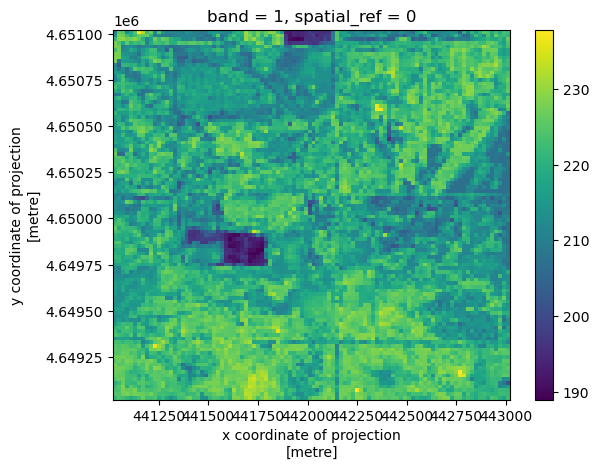

In [30]:
# Can I get max, mean, min lst from stacked da?

#min = stacked_lst_da.isel(band=0).min().plot(linestyle='--', marker='o', c='m', label='Point location', figsize=(8,5))
min = stacked_lst_da.min(dim='time')

#plt.show()
stacked_lst_da.isel(band=0).min(dim='time').plot()


### Download and extract LST data for a point.

In [39]:
# Set the point for time-series extraction.
point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)

lst_res = FH_Hydrosat(items[:num_tiles])
lst_k = lst_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=0) 
lst_dt = lst_res.datetime
type(lst_k)

using 6 processes to sample 180 assets


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGE

list

### Download and extract surface reflectance (NDVI) data for a point.
- Download only the band assets we need for NDVI.

In [40]:
# sample the sentinel2 items
s2_res = FH_Hydrosat(s2_items, asset='surface_reflectance')

# Set the point for time-series extraction.
point_wgs84 = Point(box(*bbox).centroid.x, box(*bbox).centroid.y)

# Extract time-series for RED and NIR bands.
s2_red_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=2) 
s2_nir_ts = s2_res.point_time_series_from_items(point_wgs84, tol=40, nproc=6, band=6) 
s2_dt = s2_res.datetime

using 6 processes to sample 23 assets


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGE

using 6 processes to sample 23 assets


/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd
/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/FH_Hydrosat.py:21: UserWarning: Shapely 2.0 is installed, but because PyGE

### Plot a time series of the point and mean LST in the image.

In [ ]:
centroid = clip_poly_df.geometry[0].centroid
set_x, set_y, pixtype = (centroid.x, centroid.y, 'Center Pixel') 

# Plot two time-series:
#    The LST from the point.  Same as above.
#    The mean LST from the whole image.
ax = (stacked_lst_da
      .isel(band=0)
      .sel(x=set_x, y=set_y, method='nearest', tolerance=20)
      .plot(linestyle='--', marker='o', c='m', label='Point location', figsize=(8,5))
      )

ax = (stacked_lst_da
      .isel(band=0)
      .mean(dim=('x', 'y'))
      .plot(linestyle='--', marker='o', c='b', label='Area mean')
      )

plt.title(f'time series for {pixtype} pixel')
plt.legend()
plt.grid(True)
plt.ylabel('Fused LST [K]')
plt.xticks(rotation=45)
plt.show()

### Drop files with data less than 50% coverage
Sometimes the data will have low coverage due to cloud cover or invalid pixels in the input data products. Let's remove them from the dataset using the `remove_below_data_perc()` function, plot them, and create an animation.

In [52]:
# First, stacked_lst_da was not created as an object of FH_StackedDataset.
# We'll make it an object here (or try).
LST_filtered_test = FH_StackedDataset(stacked_lst_da)

In [53]:
# to switch back and allow xarray plots
%matplotlib inline 

LST_filtered = FH_StackedDataset(LST_filtered_test.remove_below_data_perc(LST_filtered_test.ds, 0.5))
#ax = LST_filtered.ds.plot(x='x', y='y', col='time', col_wrap=5)
#ax.set_xlabels('Easting [m]')
#ax.set_ylabels('Northing [m]')
#plt.show()

#### Function for downloading HRRR two meter temperature.

In [42]:
def get_hrrr_point_data(lat, lon, start, days):
    ''' 
    Fetch met data from the HRRR model system.
    Herbie package needs to be installed:
    https://herbie.readthedocs.io/en/stable/

    Parameters:
    ----------
    lat, lon: float
        Coords from which to pull grid cell data. 
    start: str
        This is the start date for which data will be retrieved.
    days: int
        Number of days of data to retrieve.

    Return:
    -------
    ds_point: xarray dataset
        Met data for specified point.
    '''
    import pandas
    from herbie import FastHerbie

    # Create a range of dates
    DATES = pandas.date_range(
        start=start,
        periods=num_days,
        freq="1D",
    )

    # Define forecast lead time (or analysis).
    fxx = range(0, 1)

    # -----------------------------------------------
    # For long time-series analyses
    # -----------------------------------------------
    FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    FH.download("TMP:2 m")
    ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------
    # For real-time fetching of HRRR data.
    # -----------------------------------------------
    # Make FastHerbie Object.
    # FH = FastHerbie(DATES, model="hrrr", fxx=fxx)
    # Read a subset of the data with xarray.
    # ds = FH.xarray("TMP:2 m", remove_grib=False)
    # -----------------------------------------------

    # Get data values nearest single point
    ds_point = ds.herbie.nearest_points(points=(lon, lat))
   
    return (ds_point)

### Function for filling in missing dates in a dataframe.

In [43]:
def fill_in_missing_dates(sdt, ldt, df, date_col_name = 'date',fill_val = np.nan,date_format='%Y-%m-%d'):
    
    df.set_index(date_col_name,drop=True,inplace=True)
    df.index = pd.to_datetime(df.index, format = date_format)
    idx = pd.date_range(sdt, ldt)

    df=df.reindex(idx,fill_value=fill_val)

    df[date_col_name] = df.index
    df.reset_index(drop=True,inplace=True)

    return df

#### Get HRRR 2-meter Temperature & create a dataframe for it.

In [44]:
import get_hrrr as hrrr

# Get hrrr data for plotting with lst.

# Need to do a little formatting of the time given to the
# get hrr function.  Format needs to be '2020-08-01 00:00'.
hr_hrrr = hr.split(":")
start_hrrr = "{} {}:{}".format(start, hr_hrrr[0], hr_hrrr[1])
temp_2m_ds = get_hrrr_point_data(lat, lon, start_hrrr, num_days)

# Convert to dataframe and clean it up.
# Get a dataset of point hrrr and convert to dataframe for easier use.
temp_2m_df = temp_2m_ds.to_dataframe()

# Clean up df and drop uneeded columns.
drop_cols = ['metpy_crs', 'gribfile_projection', 'y', 'x', 'point']
temp_2m_df.reset_index(inplace=True)
temp_2m_df.drop(drop_cols, axis=1, inplace=True)

# Rename some of the cols
temp_2m_df.rename(columns = {'latitude':"hrrr_lat", 'longitude':"hrrr_lon"}, inplace=True)
temp_2m_df.rename(columns = {'point_latitude':"hrrr_pnt_lat", 'point_latitude':"hrrr_pnt_lon"}, inplace=True)

# Make date consistent in format.
temp_2m_df['date'] = pd.to_datetime(temp_2m_df['time'].dt.date)

👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/hrrr/20200401]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/hrrr/20200402]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/hrrr/20200403]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/hrrr/20200404]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/hrrr/20200405]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/hrrr/20200406]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/ea-assignments/ea-lst-capstone/tyler/fusion-hub-code/hrrr/20200407]
👨🏻‍🏭 Created directory: [/Users/tylercruickshank/earth-analytics/ea-a

#### Get LST from centerpoint of AOI & create a dataframe for it. 

In [47]:
# Select lst for a point in the AOI domain.
# lst_fil_ds = LST_filtered.ds.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20)
lst_fil_ds = stacked_lst_da.isel(band=0).sel(x=set_x, y=set_y, method='nearest', tolerance=20)

# Convert the output to a dataframe.
lst_fil_df = lst_fil_ds.to_dataframe(name='lst')

# Set the index/data to a date format that will be consistent with reindexing below given
# a range of dates.
lst_fil_df.index = pd.to_datetime(lst_fil_df.index).date

# Clean up df and drop uneeded columns.
drop_cols = ['spatial_ref']
lst_fil_df.drop(drop_cols, axis=1, inplace=True)
lst_fil_df.rename(columns = {'x':"x_lst", 'y':"y_lst", 'band':"lst_band"}, inplace=True)

# Fill in any dates where there is missing LST and then reset the index.
# LST sometimes will have days when no data was retrieved.
lst_df = lst_fil_df.reindex(pd.date_range(start, end, freq="D")).reset_index()

ERROR 1: Request for 346275-352174 failed with response_code=403
ERROR 1: Request for 362976-368875 failed with response_code=403
ERROR 1: Request for 379677-385576 failed with response_code=403
ERROR 1: Request for 396378-402277 failed with response_code=403
ERROR 1: Request for 413079-418978 failed with response_code=403
ERROR 1: Request for 429780-435679 failed with response_code=403
ERROR 1: Request for 446481-452380 failed with response_code=403
ERROR 1: Request for 463182-469081 failed with response_code=403
ERROR 1: Request for 346275-352174 failed with response_code=403
ERROR 1: Request for 362976-368875 failed with response_code=403
ERROR 1: Request for 379677-385576 failed with response_code=403
ERROR 1: Request for 396378-402277 failed with response_code=403
ERROR 1: Request for 413079-418978 failed with response_code=403
ERROR 1: Request for 429780-435679 failed with response_code=403
ERROR 1: Request for 446481-452380 failed with response_code=403
ERROR 1: Request for 4631

RasterioIOError: 403: Send failure: Broken pipe

ERROR 1: Request for 59694248-61101602 failed with response_code=403
ERROR 1: Request for 63473171-64892995 failed with response_code=403
ERROR 1: Request for 67256709-68670129 failed with response_code=403
ERROR 1: Request for 71025244-72434372 failed with response_code=403
ERROR 1: Request for 74804719-76211192 failed with response_code=403
ERROR 1: Request for 78586072-79992814 failed with response_code=403
ERROR 1: Request for 82370769-83780005 failed with response_code=403
ERROR 1: Request for 86148315-86683697 failed with response_code=403
ERROR 1: TIFFFillTile:Read error at row 3840, col 3840, tile 184; got 0 bytes, expected 177936
ERROR 1: TIFFReadEncodedTile() failed.
ERROR 1: IReadBlock failed at X offset 8, Y offset 8: TIFFReadEncodedTile() failed.
ERROR 1: Request for 62125091-63589587 failed with response_code=403
ERROR 1: Request for 66049128-67509786 failed with response_code=403
ERROR 1: Request for 69976512-71431849 failed with response_code=403
ERROR 1: Request for 73

#### Get min, max, mean LST from the AOI

In [26]:
# NOT DONE YET
# 
# lst_min_fil_ds = LST_filtered.ds.isel(band=0).min()

lst_min_fil_ds.values

array(188.95126, dtype=float32)

#### Merge LST and 2mT dataframes & plot.

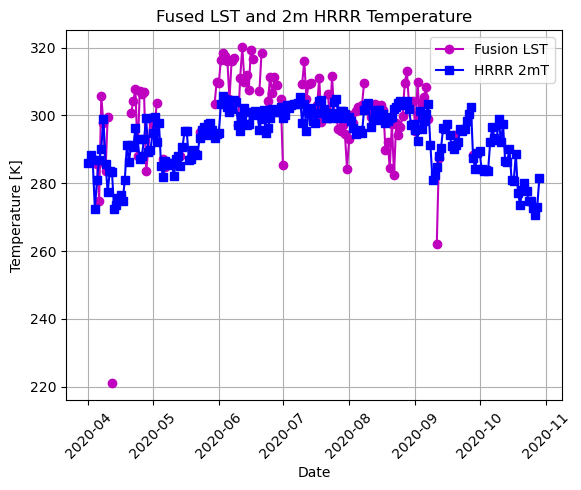

In [18]:
# Merge LST and 2mT dataframes into one larger one.
lst_2mT_df = temp_2m_df.join(lst_df)

# Dont need these two duplicate columns.
lst_2mT_df.drop(['date', 'index'], axis=1, inplace=True)

# Now plot LST and 2mT ----------------------
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['lst'], label='Fusion LST', marker='o', c='m',))# figsize=(12,7)))
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['t2m'], label='HRRR 2mT', marker='s', c='b',))

plt.title(f'Fused LST and 2m HRRR Temperature')
plt.grid(True)
plt.ylabel('Temperature [K]')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

#### Calculate CATD and add it to dataframe with LST and 2mT.


In [ ]:
# Use the pandas .sub() function to subtract 2mT from LST.
# A fill value can be added for dates where LST is not available.
lst_2mT_df['catd'] = lst_2mT_df['lst'].sub(lst_2mT_df['t2m'])

# Plot ------------------------
ax = (plt.plot(lst_2mT_df['time'], lst_2mT_df['catd'], label='CATD', marker='o', c='m',))

plt.title('CATD (LST - HRRR 2mT)')
plt.grid(True)
plt.ylabel('CATD')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.legend()
plt.show()

### Compute SENTINEL2 NDVI.

In [ ]:
s2_ndvi_ts = (np.array(s2_nir_ts) - np.array(s2_red_ts)) / (np.array(s2_nir_ts) + np.array(s2_nir_ts))

# Convert to a dataframe.
s2_ndvi_df = pd.DataFrame({'ndvi': s2_ndvi_ts,
                          'datetime': pd.to_datetime(s2_dt)}).sort_values(by='datetime')

# Get the date in the correct/consistent format.
s2_ndvi_df['date'] = [t.to_pydatetime().strftime('%Y-%m-%d') for t in s2_ndvi_df['datetime']]

# Reset the index.
s2_ndvi_df = fill_in_missing_dates('2020-04-01', '2020-10-30', s2_ndvi_df)
s2_ndvi_df['color'] = 'red'
s2_ndvi_df

### Plot sentinel2 NDVI.

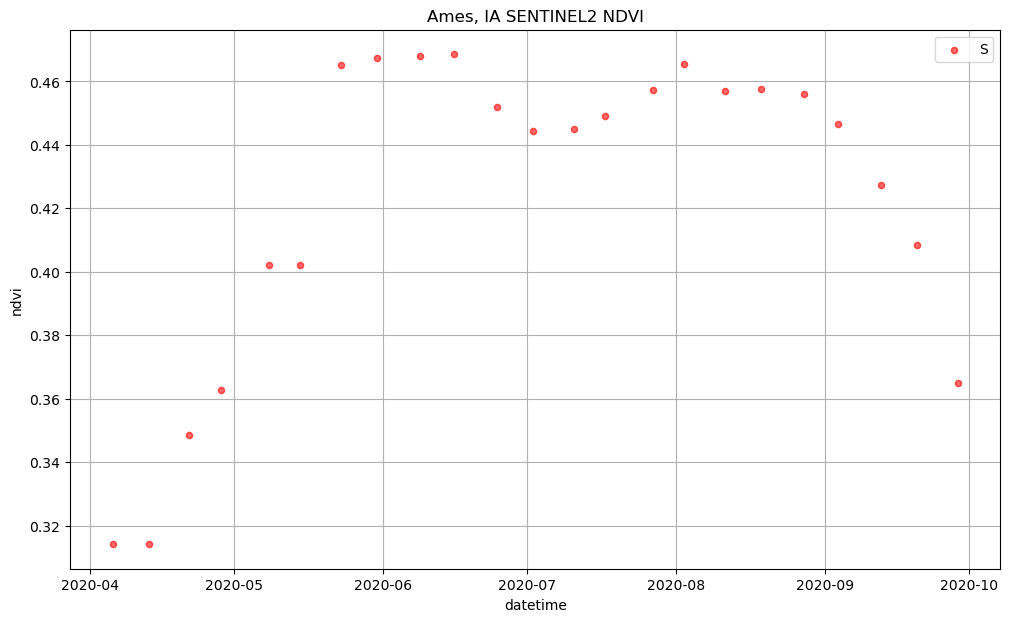

In [61]:
# Plot just the SENTINEL2 NDVI.
fig, ax = plt.subplots()

for i in s2_ndvi_df.color.unique():
    df_color = s2_ndvi_df[s2_ndvi_df.color==i]
    df_color.plot.scatter(x='datetime', y='ndvi', ax=ax, c=i, label=df_color.color.iloc[0],
                         grid=True, alpha=0.6, figsize=(12,7))


ax.set_title('Ames, IA SENTINEL2 NDVI')
plt.legend('S2-median composite NDVI')

### Merge NDVI into the dataframe holding LST, 2mT, and CATD.

In [ ]:
# Merge NDVI with catd dataframes into one larger one.
catd_ndvi_df = lst_2mT_df.join(s2_ndvi_df)
catd_ndvi_df

### Plot CATD and NDVI.

NameError: name 'catd_ndvi_df' is not defined

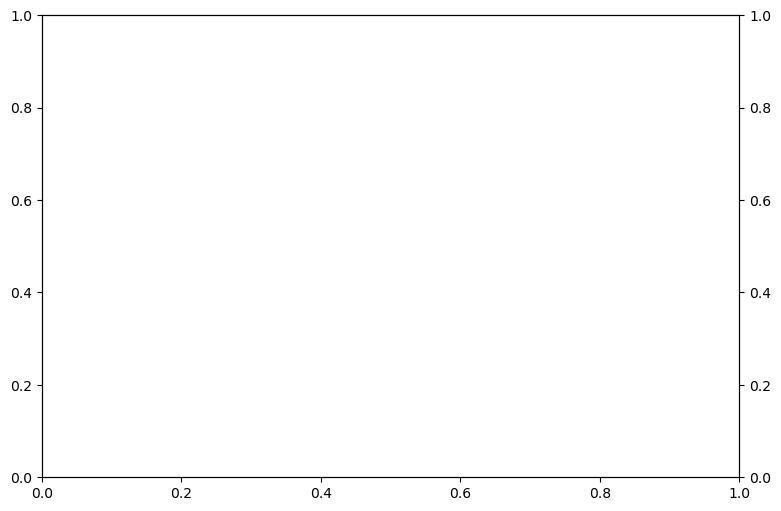

In [31]:
# Plot CATD and NDVI on twin axis ------------------------

fig, ax1 = plt.subplots(figsize=(9, 6))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

ax1.plot(catd_ndvi_df['time'], catd_ndvi_df['ndvi'], label='NDVI', marker='s', c='b')
ax2.plot(catd_ndvi_df['time'], catd_ndvi_df['catd'], label='CATD', marker='o', c='r',)

ax1.set_ylim(.30, .50)
ax2.set_ylim(25, -25)

ax1.set_ylabel("Sentinel2 NDVI", color='blue', fontsize=14)
ax2.set_ylabel("CATD", color='red', fontsize=14)

plt.title('CATD & NDVI')
plt.grid(True)

ax1.legend()
ax2.legend()
plt.show()

#### Plot rolling avergae CATD and NDVI

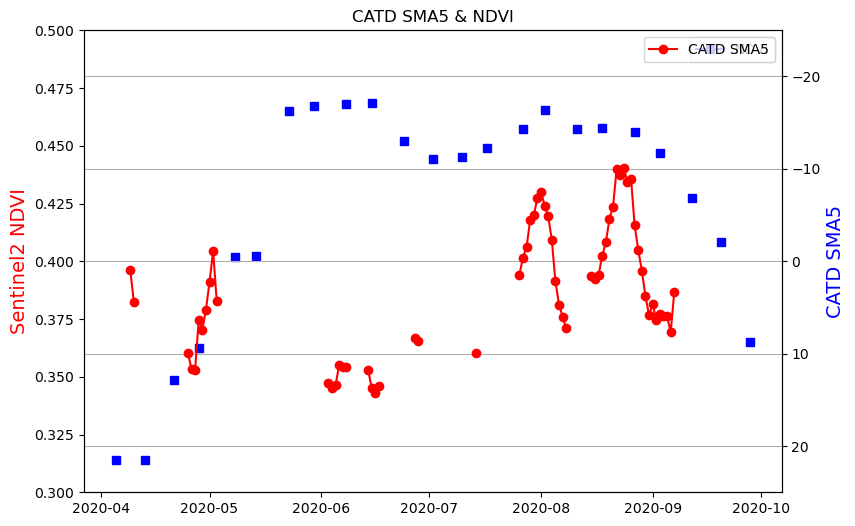

In [80]:
# Compute 5-day rolling CATD average.


# calculating simple moving average
# using .rolling(window).mean() ,
# with window size = 5
catd_ndvi_df['catd_sma5'] = catd_ndvi_df['catd'].rolling(5).mean()

# Plot CATD and NDVI on twin axis ------------------------
fig, ax1 = plt.subplots(figsize=(9, 6))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

ax1.plot(catd_ndvi_df['time'], catd_ndvi_df['ndvi'], label='NDVI', marker='s', c='b')
ax2.plot(catd_ndvi_df['time'], catd_ndvi_df['catd_sma5'], label='CATD SMA5', marker='o', c='r',)

ax1.set_ylim(.30, .50)
ax2.set_ylim(25, -25)

ax1.set_ylabel("Sentinel2 NDVI", color='red', fontsize=14)
ax2.set_ylabel("CATD SMA5", color='blue', fontsize=14)

plt.title('CATD SMA5 & NDVI')
plt.grid(True)

ax1.legend()
ax2.legend()
plt.show()